In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from scipy import stats
from tqdm import tqdm
# from skbio.stats.composition import clr
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(device)

from utils import *

import matplotlib as mpl
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

cuda:0


In [2]:
def load_model_and_data(p_model, p_data):
    annotations = torch.load(p_model)["annotations"]
    features = torch.load(p_data)["features"]
    labels = torch.load(p_data)["labels"]
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]
    
    X_train = features[train_indices]
    X_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
    
    ## clr transformation for outputs
    zero_thr = 1e-8
    gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
    y_train_clr = np.log((y_train+zero_thr)/gmean_train)
    y_test_clr = np.log((y_test+zero_thr)/gmean_train)

    ## rescale the data
    scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
    # scaler = preprocessing.RobustScaler().fit(y_train_clr)
    y_train_scaled = scaler.transform(y_train_clr)
    y_test_scaled = scaler.transform(y_test_clr)

    ## transform to tensors
    X_train_scaled=torch.from_numpy(X_train).float()
    y_train_scaled=torch.from_numpy(y_train_scaled).float()
    X_test_scaled=torch.from_numpy(X_test).float()
    y_test_scaled=torch.from_numpy(y_test_scaled).float()
    
    input_dim = len(spc_names)
    # downsize for model for synthetic_v1
    hidden_dim = 2048
    latent_dim = 512
    model = VAE_2(input_dim, latent_dim, hidden_dim).to(device)
    model.load_state_dict(torch.load(p_model)["model"])
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model

### Evaluate reconstruction

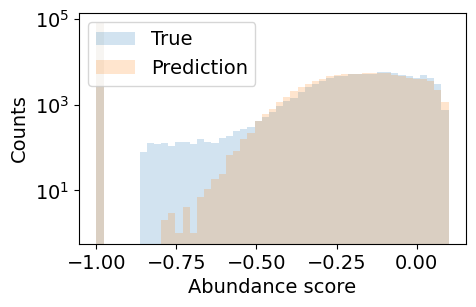

(176000,) 176000


In [3]:
hub = 6
p_model = f"../models/synthetic_v4_trophic_{hub}_trained_AE.pt"
p_data = f"../data/synthetic_v4_trophic_{hub}_filtered.pt"

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)

class CustomDataset(Dataset):
    def __init__(self, features, labels, device=None):
        self.labels = labels
        self.features = features
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.features[idx]
        return {"Features": data, "Labels": label}
Train = CustomDataset(X_train_scaled, y_train_scaled)
Test = CustomDataset(X_test_scaled, y_test_scaled)
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)

# compare initial and reconstructed features
plt.figure(figsize=(5, 3))
plt.hist(y_test_scaled.numpy().flatten(), bins=np.linspace(-1, 0.1, 50), alpha=0.2, label="True")
all_recon = []
weights = [1.0, 1.0, 0.0]
for batch in test_DS:
    b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
    recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
    recon_x = recon_x.detach().cpu().numpy().flatten()
    all_recon.extend(list(recon_x))
plt.hist(all_recon, bins=np.linspace(-1, 0.1, 50), alpha=0.2, label="Prediction")
plt.yscale("log")
plt.legend()
plt.xlabel("Abundance score")
plt.ylabel("Counts")
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_distribution_{handle}.pdf", bbox_inches="tight")
plt.show()

print(y_test_scaled.numpy().flatten().shape, len(all_recon))

20it [00:00, 83.97it/s]


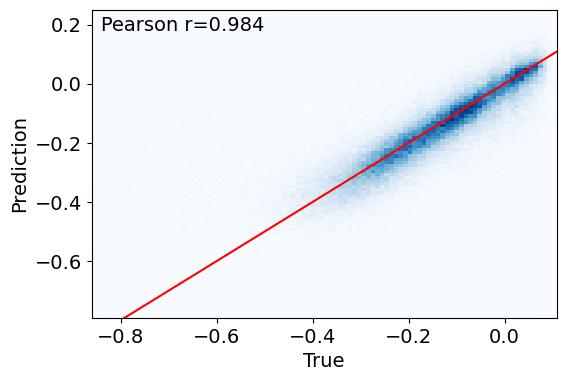

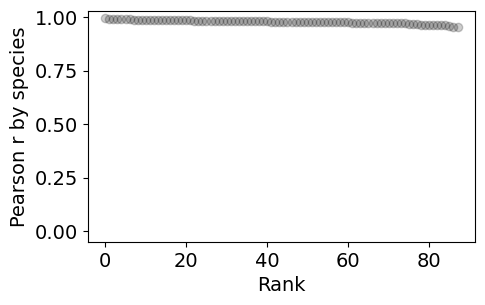

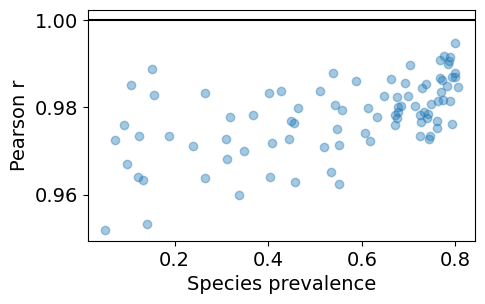

In [4]:
# check the reconstruction values
true_x_list = []
recon_x_list = []
n_batch_use = 1e3

for (idx, batch) in tqdm(enumerate(test_DS)):
    true_x = batch['Labels'].detach().numpy()
    b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
    recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
    recon_x = recon_x.detach().cpu().numpy()
    true_x_list.append(true_x)
    recon_x_list.append(recon_x)
    if(idx>=n_batch_use):
        break
        
true_x_list = np.vstack(true_x_list)
recon_x_list = np.vstack(recon_x_list)
plt.figure(figsize=(6, 4))
x=true_x_list.flatten()
y=recon_x_list.flatten()
x1 = [x[i] for i in range(len(x)) if x[i]!=-1 and y[i] !=-1]
y1 = [y[i] for i in range(len(x)) if x[i]!=-1 and y[i] !=-1]
plt.hist2d(x=x1, y=y1, norm=matplotlib.colors.PowerNorm(1), cmap='Blues', bins=100)
plt.plot([-1.0, 0.2], [-1.0, 0.2], color="r")
plt.xlabel("True")
plt.ylabel("Prediction")
r, _ = stats.pearsonr(true_x_list.flatten(), recon_x_list.flatten())
mse_ae = mean_squared_error(true_x_list.flatten(), recon_x_list.flatten(), squared=False)
plt.gca()
# plt.text(0.02, 0.98, f'MSE loss={mse_ae:.3f}', transform=plt.gca().transAxes, va='top')
plt.text(0.02, 0.98, f'Pearson r={r:.3f}', transform=plt.gca().transAxes, va='top')

handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_fit_{handle}.pdf", bbox_inches="tight")
plt.show()

# Pearson r by species
coeffs = [ stats.pearsonr(true_x_list[:, i], recon_x_list[:, i]) for i in range(true_x_list.shape[1]) ]
coeffs_sorted = sorted(enumerate(coeffs), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(5, 3))
plt.scatter(range(len(coeffs)), [val[0] for (idx, val) in coeffs_sorted], color="k", alpha=0.2)
plt.xlabel("Rank")
plt.ylabel("Pearson r by species")
plt.ylim(-0.05, 1.03)
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_pearson_by_spc_{handle}.pdf", bbox_inches="tight")
plt.show()
    
# predictibility vs prevalence
X_all = torch.vstack([X_train_scaled, X_test_scaled]).numpy()
plt.figure(figsize=(5, 3))
plt.scatter([np.sum(X_all[:, i]>0)/X_all.shape[0] for i in range(X_all.shape[1])], \
             [i[0] for i in coeffs], alpha=0.4)
plt.xlabel("Species prevalence")
plt.ylabel("Pearson r")
# plt.ylim(-0.05, 1.03)
plt.axhline(1.0, color="k")
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_pearson_vs_prev_{handle}.pdf", bbox_inches="tight")
plt.show()

# top x best predicted species
# spc_names = annotations["spcs"]
# for i in range(20):
#     print(coeffs_sorted[i][1][0], spc_names[coeffs_sorted[i][0]])

### Compare with simple traditional methods
We might not put plots in the finalized version. We should generate synthetic datasets across some different bio parameters (such as the growth rate distribution width or whatever about the resource influx) and show that AE is better than RF/EN in all/most of these cases

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor

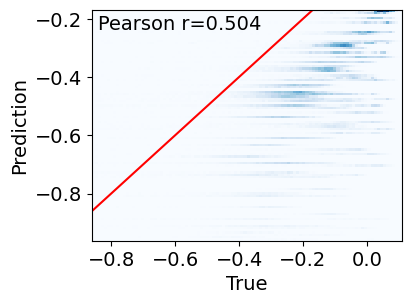

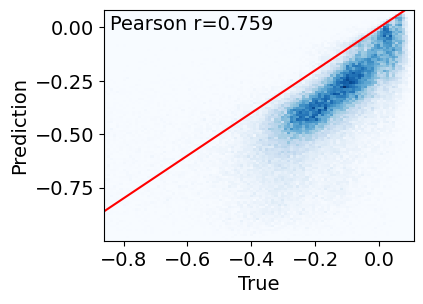

In [6]:
# RF
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled.numpy(), y_train_scaled.numpy())
y_pred_rf = rf.predict(X_test_scaled.numpy())
ccrf, p_rf = pearsonr(y_test_scaled.numpy().flatten(), y_pred_rf.flatten())
mse_rf = mean_squared_error(y_test_scaled.numpy(), y_pred_rf, squared=False)

# Elastic Net
en = MultiOutputRegressor(ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000))
en.fit(X_train_scaled.numpy(), y_train_scaled.numpy())
y_pred_en = en.predict(X_test_scaled.numpy())
ccen, p_en = pearsonr(y_test_scaled.numpy().flatten(), y_pred_en.flatten())
mse_en = mean_squared_error(y_test_scaled.numpy(), y_pred_en, squared=False)

true_x_list = []
recon_x_list = []
n_batch_use = 100

# Elastic net
true_x_list = y_test_scaled.numpy()
recon_x_list = y_pred_en
plt.figure(figsize=(4, 3))
x=true_x_list.flatten()
y=recon_x_list.flatten()
x1 = [x[i] for i in range(len(x)) if x[i]!=-1 and y[i] !=-1]
y1 = [y[i] for i in range(len(x)) if x[i]!=-1 and y[i] !=-1]
plt.hist2d(x=x1, y=y1, norm=matplotlib.colors.PowerNorm(1), cmap='Blues', bins=100)
plt.plot([-1.0, 0.2], [-1.0, 0.2], color="r")
plt.xlabel("True")
plt.xlabel("True")
plt.ylabel("Prediction")
plt.gca()
# plt.text(0.02, 0.98, f'MSE loss={mse_en:.3f}', transform=plt.gca().transAxes, va='top')
plt.text(0.02, 0.98, f'Pearson r={ccen:.3f}', transform=plt.gca().transAxes, va='top')
plt.show()


# RF
true_x_list = y_test_scaled.numpy()
recon_x_list = y_pred_rf
plt.figure(figsize=(4, 3))
x=true_x_list.flatten()
y=recon_x_list.flatten()
x1 = [x[i] for i in range(len(x)) if x[i]!=-1 and y[i] !=-1]
y1 = [y[i] for i in range(len(x)) if x[i]!=-1 and y[i] !=-1]
plt.hist2d(x=x1, y=y1, norm=matplotlib.colors.PowerNorm(1), cmap='Blues', bins=100)
plt.plot([-1.0, 0.2], [-1.0, 0.2], color="r")
plt.xlabel("True")
plt.xlabel("True")
plt.ylabel("Prediction")
r, _ = stats.pearsonr(true_x_list.flatten(), recon_x_list.flatten())
plt.gca()
# plt.text(0.02, 0.98, f'MSE loss={mse_rf:.3f}', transform=plt.gca().transAxes, va='top')
plt.text(0.02, 0.98, f'Pearson r={ccrf:.3f}', transform=plt.gca().transAxes, va='top')
plt.show()

In [49]:
hubs_list = [1, 3, 6, 12, 24]
ae_rs = []
en_rs = []
rf_rs = []

ae_mses = []
en_mses = []
rf_mses = []

for hub in hubs_list[1:]:
    ae_r, ae_mse = [], []
    en_r, en_mse = [], []
    rf_r, rf_mse = [], []
    for idx_split in tqdm(range(5)):
        p_model = f"../models/synthetic_v4_trophic_{hub}_trained_AE_{idx_split}.pt"
        p_data = f"../data/synthetic_v4_trophic_{hub}_filtered.pt"
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
        
        # autoencoder
        class CustomDataset(Dataset):
            def __init__(self, features, labels, device=None):
                self.labels = labels
                self.features = features
            def __len__(self):
                return len(self.labels)
            def __getitem__(self, idx):
                label = self.labels[idx]
                data = self.features[idx]
                return {"Features": data, "Labels": label}
        Train = CustomDataset(X_train_scaled, y_train_scaled)
        Test = CustomDataset(X_test_scaled, y_test_scaled)
        kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
        train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
        test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)
        true_x_list = []
        recon_x_list = []
        n_batch_use = 1e3
        for (idx, batch) in tqdm(enumerate(test_DS)):
            true_x = batch['Labels'].detach().numpy()
            weights = [1.0, 1.0, 0.0]
            b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
            recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
            recon_x = recon_x.detach().cpu().numpy()
            true_x_list.append(true_x)
            recon_x_list.append(recon_x)
            if(idx>=n_batch_use):
                break
        true_x_list = np.vstack(true_x_list)
        recon_x_list = np.vstack(recon_x_list)
        r, _ = stats.pearsonr(true_x_list.flatten(), recon_x_list.flatten())
        mse_ae = mean_squared_error(true_x_list.flatten(), recon_x_list.flatten(), squared=False)
        ae_r.append(r)
        ae_mse.append(mse_ae)
        
        # elastic net
        en = MultiOutputRegressor(ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000))
        en.fit(X_train_scaled.numpy(), y_train_scaled.numpy())
        y_pred_en = en.predict(X_test_scaled.numpy())
        ccen, p_en = pearsonr(y_test_scaled.numpy().flatten(), y_pred_en.flatten())
        mse_en = mean_squared_error(y_test_scaled.numpy(), y_pred_en, squared=False)
        en_r.append(ccen)
        en_mse.append(mse_en)
        
        # random forest
        rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
        rf.fit(X_train_scaled.numpy(), y_train_scaled.numpy())
        y_pred_rf = rf.predict(X_test_scaled.numpy())
        ccrf, p_rf = pearsonr(y_test_scaled.numpy().flatten(), y_pred_rf.flatten())
        mse_rf = mean_squared_error(y_test_scaled.numpy(), y_pred_rf, squared=False)
        rf_r.append(ccrf)
        rf_mse.append(mse_rf)
        
    ae_rs.append(ae_r)
    ae_mses.append(ae_mse)
    en_rs.append(en_r)
    en_mses.append(en_mse)
    rf_rs.append(rf_r)
    rf_mses.append(rf_mse)

  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
20it [00:00, 100.30it/s]A
 20%|██        | 1/5 [00:13<00:53, 13.28s/it]
0it [00:00, ?it/s]
20it [00:00, 122.62it/s]A
 40%|████      | 2/5 [00:26<00:39, 13.25s/it]
0it [00:00, ?it/s]
20it [00:00, 115.92it/s]A
 60%|██████    | 3/5 [00:39<00:26, 13.23s/it]
0it [00:00, ?it/s]
20it [00:00, 126.75it/s][A
 80%|████████  | 4/5 [00:53<00:13, 13.39s/it]
0it [00:00, ?it/s]
20it [00:00, 112.11it/s]A
  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
20it [00:00, 121.04it/s]A
 20%|██        | 1/5 [00:18<01:15, 18.93s/it]
0it [00:00, ?it/s]
20it [00:00, 118.38it/s]A
 40%|████      | 2/5 [00:37<00:56, 18.80s/it]
0it [00:00, ?it/s]
20it [00:00, 111.48it/s]A
 60%|██████    | 3/5 [00:56<00:37, 18.97s/it]
0it [00:00, ?it/s]
20it [00:00, 98.23it/s][A
 80%|████████  | 4/5 [01:15<00:18, 18.90s/it]
0it [00:00, ?it/s]
20it [00:00, 145.02it/s]
  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
20it [00:00, 105.53it/s]A
 20%|██        | 1/5 [0

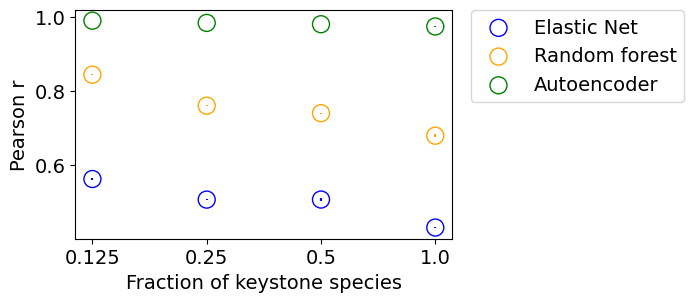

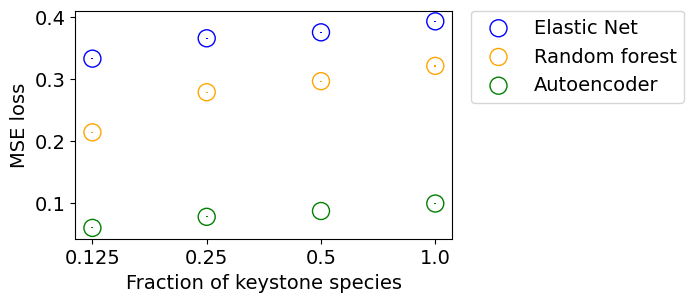

In [83]:
def plot_performance(en, rf, ae, performance_name):
    plt.figure(figsize=(7, 3))
    plt.scatter(np.arange(0, len(en)), [np.mean(i) for i in en], s=150, facecolors="None", edgecolor='b', label="Elastic Net")
    plt.errorbar(np.arange(0, len(en)), [np.mean(i) for i in en], yerr=[np.std(i) for i in en], color='b', linestyle="None")
    
    plt.scatter(np.arange(0, len(rf)), [np.mean(i) for i in rf], s=150, facecolors="None", edgecolor='orange', label="Random forest")
    plt.errorbar(np.arange(0, len(rf)), [np.mean(i) for i in rf], yerr=[np.std(i) for i in rf], color='orange', linestyle="None")
    
    plt.scatter(np.arange(0, len(ae)), [np.mean(i) for i in ae], s=150, facecolors="None", edgecolor='g', label = "Autoencoder")
    plt.errorbar(np.arange(0, len(ae)), [np.mean(i) for i in ae], yerr=[np.std(i) for i in ae], color='g', linestyle="None")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    plt.xticks(range(4), [np.round(i/24, 3) for i in [3, 6, 12, 24]])
    plt.xlabel("Fraction of keystone species")
    plt.ylabel(performance_name)
    
plot_performance(en_rs, rf_rs, ae_rs, "Pearson r")
plt.savefig(f"../figures/compare_methods_pearsonr.pdf", bbox_inches="tight")
plot_performance(en_mses, rf_mses, ae_mses, "MSE loss")
plt.savefig(f"../figures/compare_methods_mse.pdf", bbox_inches="tight")

### Keystoneness / Keystone-Interactions

#### 1. Keystoneness and interactions from single species flips

In [81]:
'''
Flip a species's binary in the input and reconstruct the abundances. 
Compare it with the re-normalized abundance of other species. 
'''
# get parameter of data preprocessing so that we can transform back to relative abundance afterwards
def get_preprocess(p_data, p_model):
    _, _, _, _, annotations, model = load_model_and_data(p_model, p_data)
    train_indices = annotations["train_idx"]
    test_indices = annotations["test_idx"]
    
    features = torch.load(p_data)["features"]
    labels = torch.load(p_data)["labels"]
    spc_names = torch.load(p_data)["names"]
    
    original_indices = np.arange(len(features))
    train_indices, test_indices = train_test_split(
        original_indices,
        test_size=0.2,
        random_state=42,
    )
    X_train = features[train_indices]
    X_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
#     print(y_test)

    ## clr transformation for outputs
    zero_thr = 1e-8
    gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
    y_train_clr = np.log((y_train+zero_thr)/gmean_train)
    y_test_clr = np.log((y_test+zero_thr)/gmean_train)

    ## rescale the data
    scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
    
    return gmean_train, scaler

def preproc_inverse(abundance_scores, scaler, zero_thr=1e-8):
    before_scale = scaler.inverse_transform(abundance_scores)
#     before_scale = abundance_scores
    exp_vals = np.exp(before_scale)
    return exp_vals / (np.sum(exp_vals, axis=1, keepdims=True)+zero_thr)

In [11]:
from collections import defaultdict
from scipy.spatial.distance import braycurtis

def calculate_flip_keystoneness(p_model, p_data, batches_use=100):

    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
    class CustomDataset(Dataset):
        def __init__(self, features, labels, device=None):
            self.labels = labels
            self.features = features
        def __len__(self):
            return len(self.labels)
        def __getitem__(self, idx):
            label = self.labels[idx]
            data = self.features[idx]
            return {"Features": data, "Labels": label}
    Train = CustomDataset(X_train_scaled, y_train_scaled)
    Test = CustomDataset(X_test_scaled, y_test_scaled)
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
    test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)

    gmean, scaler = get_preprocess(p_data, p_model)
    zero_thr = 1e-8
    model.eval()

    # Keystoneness
    num_species = X_test_scaled.shape[1]
    keystone_distributions = defaultdict(list)
    key_interactions = np.empty((num_species, num_species), dtype=object)
    for i in range(num_species):
        for j in range(num_species):
            key_interactions[i, j] = []

    for bdx, batch in tqdm(enumerate(train_DS)):
        x = batch['Features'].to(device)
        with torch.no_grad():
            b, nb, _, _ = model(x)
            recon_orig = (b>0.5).float()*nb + (b<0.5).float()*(-1)

        for i in range(x.shape[0]):
            x_i = x[i].clone()
            recon_i_scaled = recon_orig[i].cpu().numpy()
            if x_i.sum() == 0:
                continue  # skip samples with no microbes present

            present_indices = torch.nonzero(x_i).flatten()

            # get the "unperturbed" abundances for all possible 1->0 flips of this sample
            recon_i_scaled_all = np.tile(recon_i_scaled, (len(present_indices), 1))
            b_relab_all = np.tile(b[i].cpu().numpy(), (len(present_indices), 1))
            orig_relab_all = preproc_inverse(recon_i_scaled_all, scaler)
            orig_relab_all = (b_relab_all>0.5)*orig_relab_all
            renorm_orig_relab_all = orig_relab_all.copy()
            for idx, j in enumerate(present_indices):
                renorm_orig_relab_all[idx, j.item()] = 0.0
            renorm_orig_relab_all /= np.sum(renorm_orig_relab_all, axis=1, keepdims=True) 
            # get the "perturbed" abundances for all possible 1->0 flips of this sample
            x_pert = torch.tile(x_i, (len(present_indices), 1))
            for idx, j in enumerate(present_indices):
                x_pert[idx, j.item()] = 0
            with torch.no_grad():
                b_pert, nb_pert, *_ = model(x_pert)
                recon_perturbed_scaled = (b_pert>0.5).float()*nb_pert + (b_pert<0.5).float()*(-1)
            perturbed_relab_all = preproc_inverse(recon_perturbed_scaled.cpu().numpy(), scaler)
            perturbed_relab_all = (b_pert.cpu().numpy()>0.5)*perturbed_relab_all

            # get the bray-curtis distances
            for idx, j in enumerate(present_indices):
                j = j.item()
                dist = braycurtis(renorm_orig_relab_all[idx], perturbed_relab_all[idx])
                keystone_distributions[j].append(dist)

            # get the interactions
            difference = np.log10( (perturbed_relab_all+zero_thr)/(renorm_orig_relab_all+zero_thr) )
            for idx, j in enumerate(present_indices):
                j = j.item()
                for jdx in range(num_species):
                    if(renorm_orig_relab_all[idx, jdx]>0):
                        key_interactions[j, jdx].append(difference[idx, jdx])

        bdx+=1
        if(bdx>=batches_use): break

    # Compute average keystone score per species
    keystone_scores = {
        i: np.mean(dists) for i, dists in keystone_distributions.items()
    }
                
    return keystone_scores, key_interactions

In [209]:
# hub = 6
# p_model = f"../models/synthetic_v4_trophic_{hub}_trained_AE.pt"
# p_data = f"../data/synthetic_v4_trophic_{hub}_filtered.pt"

# do this for all data
hubs_list = [1, 3, 6, 12, 24]
all_keystone_scores = []
all_key_interactions = []
all_annotations = []

for hub in hubs_list:
    p_model = f"../models/synthetic_v4_trophic_{hub}_trained_AE.pt"
    p_data = f"../data/synthetic_v4_trophic_{hub}_filtered.pt"
    
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]
    num_species = len(spc_names)
    
    keystone_scores, key_interactions = calculate_flip_keystoneness(p_model, p_data, 100)
    all_key_interactions.append(key_interactions)
    all_keystone_scores.append(keystone_scores)
    all_annotations.append(annotations)

80it [01:56,  1.45s/it]
80it [02:36,  1.96s/it]
80it [03:48,  2.86s/it]
80it [04:30,  3.38s/it]
80it [05:15,  3.94s/it]


In [4]:
# define function to get interaction matrix visualization
def interaction_from_flip_keystoneness(key_interactions, num_species):
    heatmap = np.zeros([num_species, num_species])
    xxs, xys = [], []
    for i in range(num_species):
        for j in range(num_species):
            if(len(key_interactions[i, j])>0):
                heatmap[i, j] = np.mean(key_interactions[i, j])
            else:
                xxs.append(i)
                xys.append(j)
    return heatmap, xxs, xys

# def keystone_list_from_flip_keystoneness(key_interactions, num_species):
#     heatmap = np.zeros([num_species, num_species])
#     for i in range(num_species):
#         for j in range(num_species):
#             if(len(key_interactions[i, j])>0):
#                 heatmap[i, j] = np.mean(np.abs(key_interactions[i, j]))
#     return np.mean(heatmap, axis=0)   

# pickle.dump({"all_key_interactions": [interaction_from_flip_keystoneness(i, i.shape[0]) for i in all_key_interactions], 
# #              "all_key_interactions": all_key_interactions,
#              "all_keystone_scores": all_keystone_scores, 
#              "all_annotations": all_annotations}, 
#             open("../synthetic_data/data_v4/keystone_analysis.pkl", "wb"))

#### Interactions

Consumption $C_{\alpha i} = \left(\frac{\partial \dot{R_i}}{\partial N_\alpha}\right)_{\text{consume}}=g_{\alpha i}R_i$

Prodution $P_{\alpha i} = \left(\frac{\partial \dot{R_i}}{\partial N_\alpha}\right)_{\text{produce}}=f\sum_j D^{\alpha}_{j\to i}g_{\alpha j} R_j$

Facilitation $A_{\text{facil}}=C\cdot P^T$

Competition $A_{\text{comp}}=-C\cdot C^T$

To reflect the facilitation over layers:
$A'_{\text{facil}} = (I-f\cdot\frac{A_{\text{facil}}}{\max(A_{\text{facil}})})^{-1}-I$

In [93]:
# define functions for interactions from parameters
def make_c(params, f, Rs):
    n_spc = params["g"].shape[0]
    return params["g"]*np.outer(np.ones(n_spc), Rs)

# production matrix
def make_p(params, f, Rs):
    n_res = Rs.shape[0]
    n_spc = params["g"].shape[0]
    c, g, p, o = params["c"], params["g"], params["p"], params["o"]
    gajRj = g*np.tile(Rs, (n_spc, 1))
    return o * f * np.outer(np.sum(gajRj, axis=1), np.ones(n_res))

def mat_facil(params, f, Rs):
    c = make_c(params, f, Rs)
    p = make_p(params, f, Rs)
    a_facil = p @ (c.T)
    I = np.eye(a_facil.shape[0])
    a_facil = a_facil/a_facil.max()
    a_facil = np.linalg.inv(I - f*a_facil)-I #trophic layer cascade effect
    return a_facil

def mat_comp(params, f, Rs):
    c = make_c(params, f, Rs)
    a_comp = -c @ (c.T)
    a_comp = -a_comp/a_comp.min()
    return a_comp

In [94]:
# make a function that makes the interactions plot nicer
def stratify_plot(x, y, bins):
    x_new = np.linspace(np.min(x), np.max(x), bins+1)
    y_new = [[] for i in range(bins)]
    for i in range(len(x)):
        for j in range(bins):
            if(x[i]>=x_new[j] and x[i]<=x_new[j+1]):
                y_new[j].append(y[i])
    return [x_new[:-1][i] for i in range(bins) if len(y_new[i])>0], [i for i in y_new if len(i)>0]

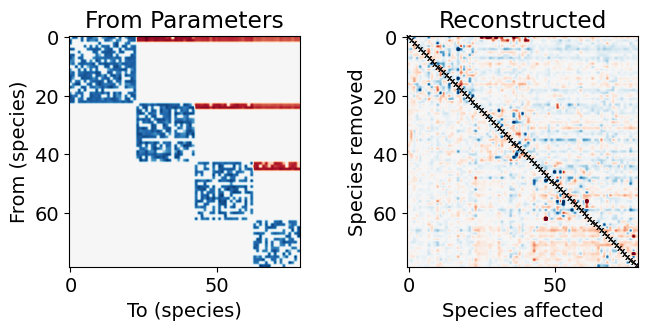

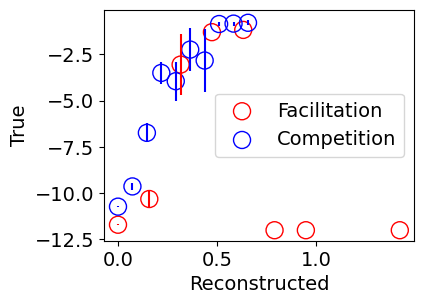

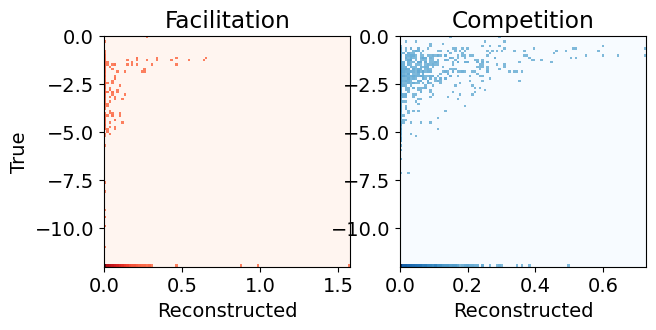

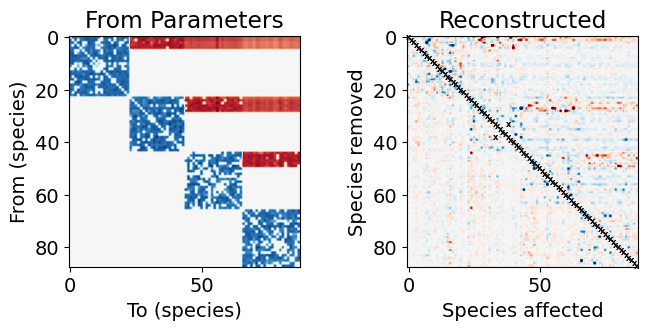

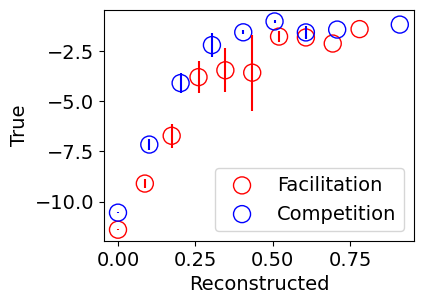

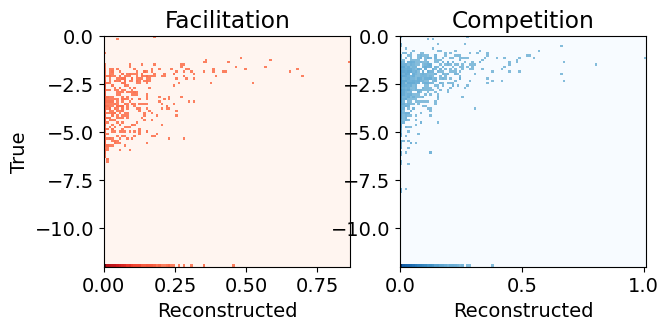

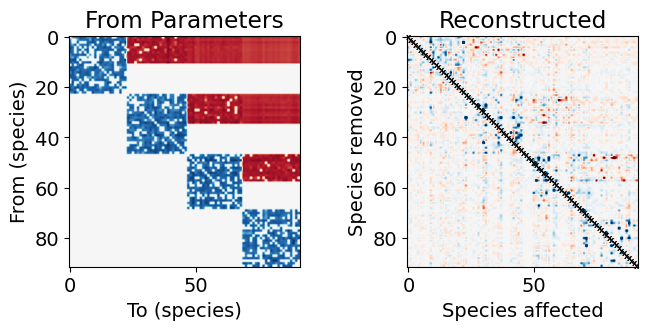

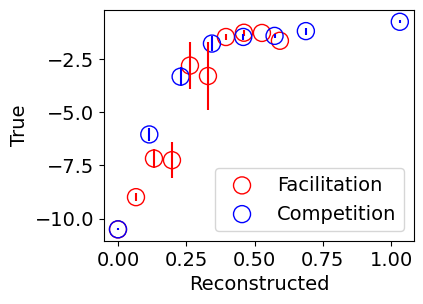

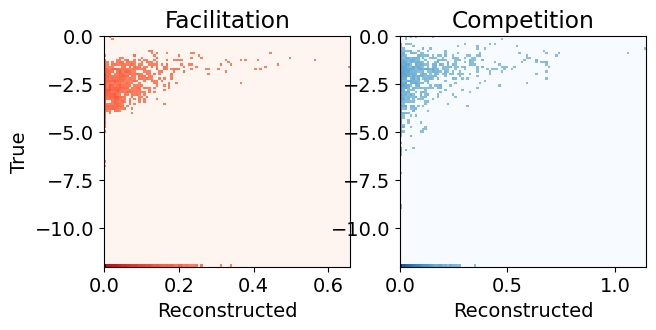

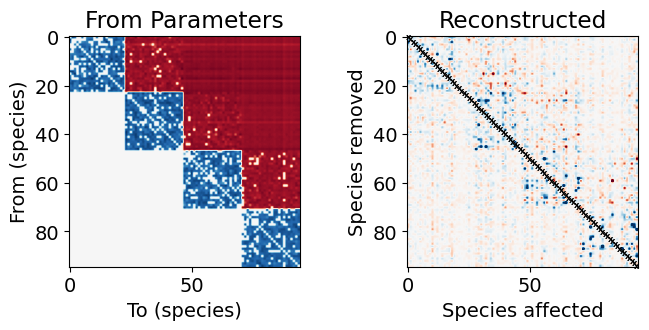

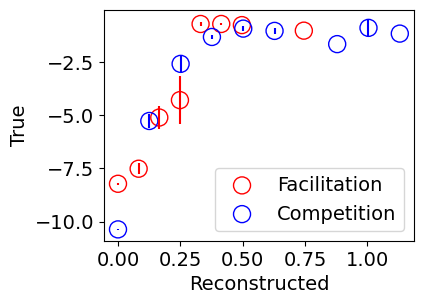

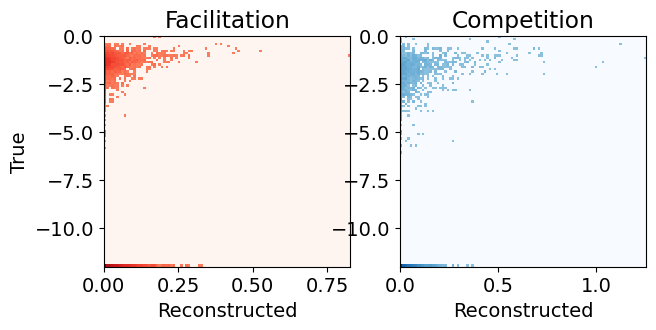

In [95]:
# make the interaction plots

data = pickle.load(open("../synthetic_data/data_v4/keystone_analysis.pkl", "rb"))
all_key_interactions = data["all_key_interactions"]
all_keystone_scores = data["all_keystone_scores"]
all_annotations = data["all_annotations"]

hubs_list = [1, 3, 6, 12, 24]

for h_idx, hub in enumerate(hubs_list[1:]):
    
    heatmap, xxs, xys = all_key_interactions[1:][h_idx]
    annotations = all_annotations[1:][h_idx]
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]
    
    p_params = f"../synthetic_data/data_v4/parameters_trophic_4_hubs_{hub}.pkl"
    p_Rs = f"../synthetic_data/data_v4/trophic_{hub}_all_diets_Rs.pkl"
    p_data = f"../synthetic_data/data_v4/trophic_{hub}_all_diets.pkl"
    params = pickle.load(open(p_params, "rb"))
    all_Rs = pickle.load(open(p_Rs, "rb"))
    all_Rs = all_Rs*(all_Rs>0)
    Rs = all_Rs.values[0, :]
    a_facil = mat_facil(params[0], 0.9, Rs) # f=0.9 used in simulations
    a_comp = mat_comp(params[0], 0.9, Rs)
    for i in range(a_comp.shape[0]):
        a_comp[i, i] = 0
    all_spcs = list(pickle.load(open(p_data, "rb")).columns)
    idxs = [i in spc_names for i in all_spcs]
    a_facil = a_facil[idxs, :][:, idxs]
    a_facil = a_facil/a_facil.max()
    a_comp = a_comp[idxs, :][:, idxs]  
    a_comp = -a_comp/a_comp.min()  
    
    handle = f"synthetic_v4_trophic_{hub}"
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].imshow(np.log10(1e-12-a_comp) - np.log10(1e-12+a_facil), cmap='RdBu')
    axs[0].set_ylabel("From (species)")
    axs[0].set_xlabel("To (species)")
    axs[0].set_title("From Parameters")
    axs[1].imshow(heatmap, cmap="RdBu", vmin=-0.4, vmax=0.4) # most of values are within [-0.4, 0.4]
    for x, y in zip(xxs, xys):
        axs[1].text(x, y, 'x',
                color='black',
                ha='center',
                va='center',
                fontsize=6, 
                weight='bold')
    axs[1].set_xlabel("Species affected")
    axs[1].set_ylabel("Species removed")
    axs[1].set_title("Reconstructed")
    plt.savefig(f"../figures/keystoneness_i_to_j_{handle}.pdf", bbox_inches="tight")
    plt.show()
    
    
    x = (-heatmap*(heatmap<0)).flatten()
    y = np.log10(1e-12+a_facil).flatten()
    x1, y1 = stratify_plot(x, y, 10) 
    plt.figure(figsize=(4, 3))
    plt.scatter(x1, [np.mean(i) for i in y1], s=150, facecolors="None", edgecolors="r", label="Facilitation")
    plt.errorbar(x1, [np.mean(i) for i in y1], yerr=[np.std(i)/np.sqrt(len(i)) for i in y1], linestyle="None", color="r")
    plt.xlabel("Reconstructed")
    plt.ylabel("True")

    x = (heatmap*(heatmap>0)).flatten()
    y = np.log10(1e-12-a_comp).flatten()
    x1, y1 = stratify_plot(x, y, 10) 
    # plt.figure(figsize=(4, 3))
    plt.scatter(x1, [np.mean(i) for i in y1], s=150, facecolors="None", edgecolors="b", label="Competition")
    plt.errorbar(x1, [np.mean(i) for i in y1], yerr=[np.std(i)/np.sqrt(len(i)) for i in y1], linestyle="None", color="b")
    plt.xlabel("Reconstructed")
    plt.ylabel("True")
    plt.legend()
    plt.savefig(f"../figures/keystoneness_i_to_j_compare1{handle}.pdf", bbox_inches="tight")
    plt.show()
    
    
    # actual correlation...
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    axs[0].hist2d(x = (-heatmap*(heatmap<0)).flatten(), y = np.log10(1e-12+a_facil).flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='Reds', bins=100)
    axs[1].hist2d(x = (heatmap*(heatmap>0)).flatten(), y = np.log10(1e-12-a_comp).flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='Blues', bins=100)

    axs[0].set_xlabel("Reconstructed")
    axs[0].set_ylabel("True")
    axs[0].set_title("Facilitation")
    axs[1].set_xlabel("Reconstructed")
    axs[1].set_title("Competition")
    plt.savefig(f"../figures/keystoneness_i_to_j_compare2{handle}.pdf", bbox_inches="tight")
    plt.show()

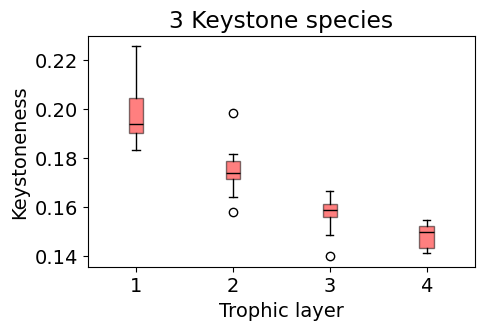

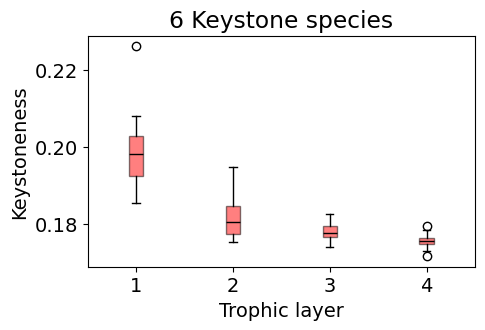

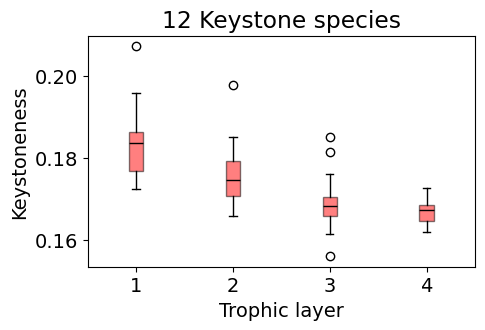

In [84]:
# make the keystone plots
data = pickle.load(open("../synthetic_data/data_v4/keystone_analysis.pkl", "rb"))
all_key_interactions = data["all_key_interactions"]
all_keystone_scores = data["all_keystone_scores"]
all_annotations = data["all_annotations"]

hubs_list = [1, 3, 6, 12, 24]

nl = 4
def rank_scores(keystone_scores, hubs, spc_names):
    layers = [0, 24, 48, 72, 96]
    hubs_scores = [[] for i in range(nl)]
    non_hubs_scores = [[] for i in range(nl)]
    for key in keystone_scores:
        key_name=int(spc_names[key][1:])
        for idx, i in enumerate(layers):
            if(layers[idx]<=key_name and key_name<layers[idx+1]):
                if(key_name % 24 < hubs):
                    hubs_scores[idx].append(keystone_scores[key])
                else:
                    non_hubs_scores[idx].append(keystone_scores[key])
                break
    return hubs_scores, non_hubs_scores

for h_idx, hubs in enumerate(hubs_list[1:4]):
    '''
    original keystone scores
    '''
    scores = all_keystone_scores[1:4][h_idx]
    
    annotations = all_annotations[1:4][h_idx]
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]
    hubs_scores, non_hubs_scores = rank_scores(scores, hubs, spc_names)

    x1s = []
    y1s = []
    for i in range(nl):
        x1s.append(i)
        y1s.append(hubs_scores[i]+non_hubs_scores[i])

    fig, ax = plt.subplots(figsize=(5, 3))
    box1 = ax.boxplot(y1s, positions=x1s, widths=0.15,patch_artist=True,
                      boxprops=dict(facecolor='r', alpha=0.5, color='k'),
                      medianprops=dict(color='black'))
#     if(len(y2s)>0):
#         box2 = ax.boxplot(y2s, positions=x2s, widths=0.15,patch_artist=True,
#                           boxprops=dict(facecolor='orange', color='blue'),
#                           medianprops=dict(color='black'))
#         handles = [box1["boxes"][0], box2["boxes"][0]]
#         labels = ['Hubs', 'Non-hubs']
#         ax.legend(handles, labels, loc='upper right')
    ax.set_xticks([0, 1, 2, 3], [1, 2, 3, 4])
    ax.set_xlabel("Trophic layer")
    ax.set_ylabel("Keystoneness")
    ax.set_title(f'{hubs_list[h_idx+1]} Keystone species')
    handle = f"synthetic_v4_trophic_{hubs}"
    plt.savefig(f"../figures/keystoneness_{handle}.pdf", bbox_inches="tight")
    plt.show()

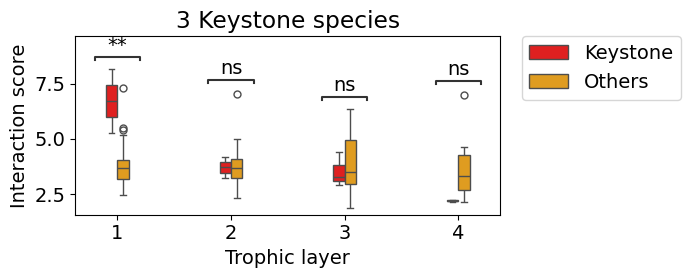

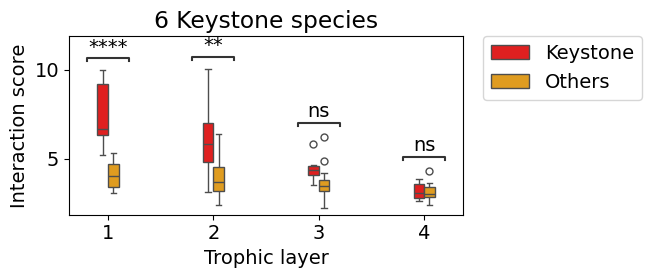

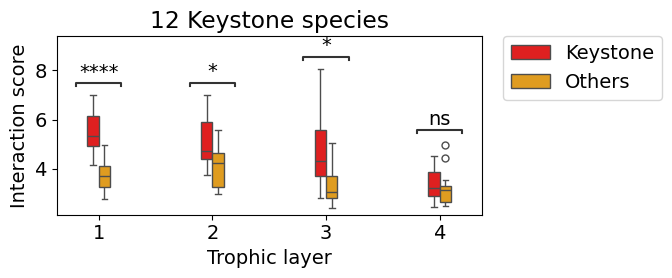

In [16]:
# make the keystone plots with interaction score
from statannotations.Annotator import Annotator

data = pickle.load(open("../synthetic_data/data_v4/keystone_analysis.pkl", "rb"))
all_key_interactions = data["all_key_interactions"]
all_keystone_scores = data["all_keystone_scores"]
all_annotations = data["all_annotations"]

hubs_list = [1, 3, 6, 12, 24]

nl = 4
def rank_scores(keystone_scores, hubs, spc_names):
    layers = [0, 24, 48, 72, 96]
    hubs_scores = [[] for i in range(nl)]
    non_hubs_scores = [[] for i in range(nl)]
    for key in keystone_scores:
        key_name=int(spc_names[key][1:])
        for idx, i in enumerate(layers):
            if(layers[idx]<=key_name and key_name<layers[idx+1]):
                if(key_name % 24 < hubs):
                    hubs_scores[idx].append(keystone_scores[key])
                else:
                    non_hubs_scores[idx].append(keystone_scores[key])
                break
    return hubs_scores, non_hubs_scores

for h_idx, hubs in enumerate(hubs_list[1:4]):
    '''
    use the interaction heatmap to make keystone scores
    '''
    heatmap, xxs, xys = all_key_interactions[1:4][h_idx]
    scores = {i: np.sum(np.abs(heatmap), axis=1)[i] for i in range(heatmap.shape[0])}
#     scores = all_keystone_scores[1:4][h_idx]
#     scores = {i: np.sum(heatmap, axis=1)[i] for i in range(heatmap.shape[0])}
    
    annotations = all_annotations[1:4][h_idx]
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]
    hubs_scores, non_hubs_scores = rank_scores(scores, hubs, spc_names)
    
    layers = []
    groups = []
    values = []
    for layer in range(nl):
        layers += [f'{layer+1}'] * (len(hubs_scores[layer])+len(non_hubs_scores[layer]))
        groups += ['Keystone']*len(hubs_scores[layer]) + ["Others"]*len(non_hubs_scores[layer])
        values += hubs_scores[layer]+non_hubs_scores[layer]
    data = {
    'Trophic layer': layers,
    'Species': groups,
    'Keystone score': values
    }
    df = pd.DataFrame(data)
    
    pairs = [
    (('1', 'Keystone'), ('1', 'Others')),
    (('2', 'Keystone'), ('2', 'Others')),
    (('3', 'Keystone'), ('3', 'Others')),
    (('4', 'Keystone'), ('4', 'Others'))
    ]
    
    flier_style = dict(marker='o', markerfacecolor='None', markersize=5)
    palette = ["r", "orange"]
    
    plt.figure(figsize=(7, 3))
    ax = sns.boxplot(x='Trophic layer', y='Keystone score', hue='Species', data=df, width=0.2, palette=palette, flierprops=flier_style)
    plt.xlabel('Trophic layer')
    plt.ylabel('Interaction score')
#     plt.ylabel("Keystonness (Bray-Curtis)")
    plt.title(f'{hubs_list[h_idx+1]} Keystone species')
    
    annotator = Annotator(ax, pairs, data=df, x='Trophic layer', y='Keystone score', hue='Species', verbose=False)
    annotator.configure(test='t-test_ind', text_format='star', loc='inside')
    annotator.apply_test()
    annotator.annotate()
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
#     handle = f"synthetic_v4_trophic_{hubs}"
#     plt.savefig(f"../figures/interaction_score_{handle}.pdf", bbox_inches="tight")
    plt.show()

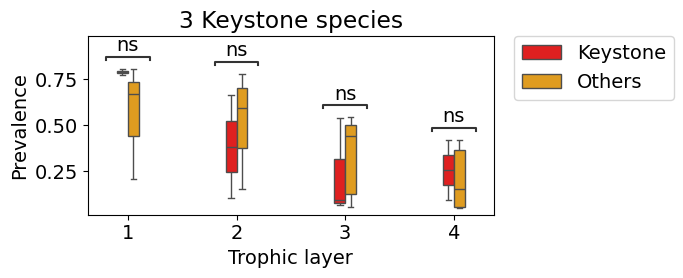

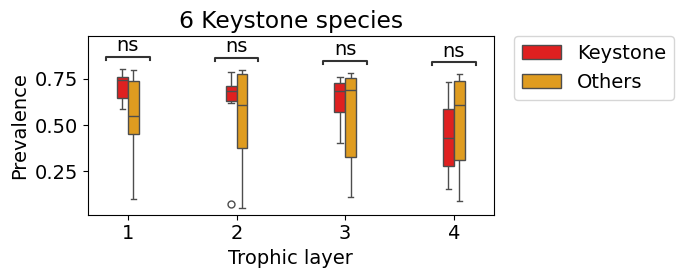

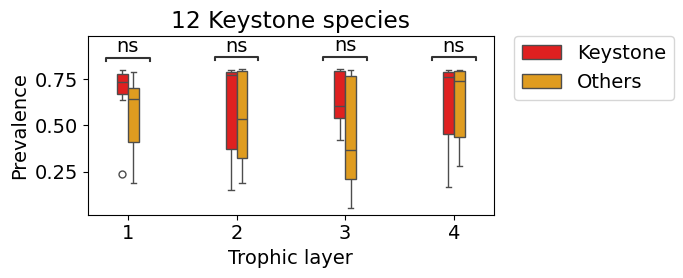

In [89]:
from statannotations.Annotator import Annotator

data = pickle.load(open("../synthetic_data/data_v4/keystone_analysis.pkl", "rb"))
all_key_interactions = data["all_key_interactions"]
all_keystone_scores = data["all_keystone_scores"]
all_annotations = data["all_annotations"]

hubs_list = [1, 3, 6, 12, 24]

nl = 4
def rank_scores(keystone_scores, hubs, spc_names):
    layers = [0, 24, 48, 72, 96]
    hubs_scores = [[] for i in range(nl)]
    non_hubs_scores = [[] for i in range(nl)]
    for key in keystone_scores:
        key_name=int(spc_names[key][1:])
        for idx, i in enumerate(layers):
            if(layers[idx]<=key_name and key_name<layers[idx+1]):
                if(key_name % 24 < hubs):
                    hubs_scores[idx].append(keystone_scores[key])
                else:
                    non_hubs_scores[idx].append(keystone_scores[key])
                break
    return hubs_scores, non_hubs_scores

for h_idx, hubs in enumerate(hubs_list[1:4]):
    
    p_model = f"../models/synthetic_v4_trophic_{hubs}_trained_AE.pt"
    p_data = f"../data/synthetic_v4_trophic_{hubs}_filtered.pt"
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
    labels = torch.load(p_data)["labels"]
    
    annotations = all_annotations[1:4][h_idx]
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]
    
    heatmap, xxs, xys = all_key_interactions[1:4][h_idx]
    abund_scores = {i:np.log10(np.mean(labels, axis=0)[i]) for i in range(labels.shape[1])}
    prev_scores = {i:np.mean(labels>0, axis=0)[i] for i in range(labels.shape[1])}
    
    hubs_scores, non_hubs_scores = rank_scores(prev_scores, hubs, spc_names)
    
    layers = []
    groups = []
    values = []
    for layer in range(nl):
        layers += [f'{layer+1}'] * (len(hubs_scores[layer])+len(non_hubs_scores[layer]))
        groups += ['Keystone']*len(hubs_scores[layer]) + ["Others"]*len(non_hubs_scores[layer])
        values += hubs_scores[layer]+non_hubs_scores[layer]
    data = {
    'Trophic layer': layers,
    'Species': groups,
    'Keystone score': values
    }
    df = pd.DataFrame(data)
    
    pairs = [
    (('1', 'Keystone'), ('1', 'Others')),
    (('2', 'Keystone'), ('2', 'Others')),
    (('3', 'Keystone'), ('3', 'Others')),
    (('4', 'Keystone'), ('4', 'Others'))
    ]
    
    flier_style = dict(marker='o', markerfacecolor='None', markersize=5)
    palette = ["r", "orange"]
    
    plt.figure(figsize=(7, 3))
    ax = sns.boxplot(x='Trophic layer', y='Keystone score', hue='Species', data=df, width=0.2, palette=palette, flierprops=flier_style)
    plt.xlabel('Trophic layer')
#     plt.ylabel('$\\log_{10}$(Abundance)')
    plt.ylabel('Prevalence')
#     plt.yscale('log')
    plt.title(f'{hubs_list[h_idx+1]} Keystone species')
    
    annotator = Annotator(ax, pairs, data=df, x='Trophic layer', y='Keystone score', hue='Species', verbose=False)
    annotator.configure(test='t-test_ind', text_format='star', loc='inside')
    annotator.apply_test()
    annotator.annotate()
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    handle = f"synthetic_v4_trophic_{hubs}"
    plt.savefig(f"../figures/prevalence_score_{handle}.pdf", bbox_inches="tight")
    plt.show()

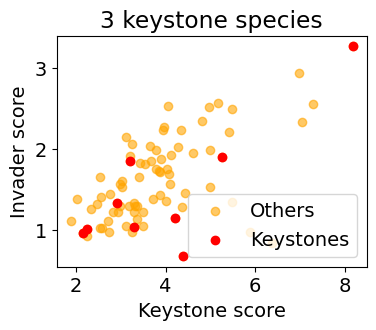

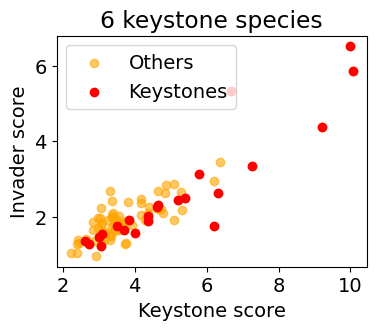

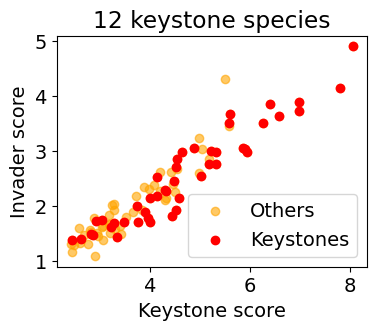

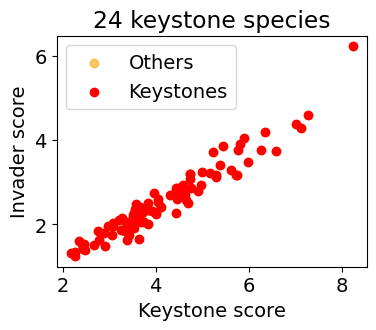

In [24]:
# keystoneness vs prevalence
data = pickle.load(open("../synthetic_data/data_v4/keystone_analysis.pkl", "rb"))
all_keystone_scores = data["all_keystone_scores"]
all_key_interactions = data["all_key_interactions"]

data = pickle.load(open("../synthetic_data/data_v4/invader_analysis.pkl", "rb"))
all_invader_scores = data["all_invader_scores"]
all_inv_interactions = data["all_inv_interactions"]
all_annotations = data["all_annotations"]

for h_idx, hub in enumerate(hubs_list[1:]):
    p_model = f"../models/synthetic_v4_trophic_{hub}_trained_AE.pt"
    p_data = f"../data/synthetic_v4_trophic_{hub}_filtered.pt"
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
    labels = torch.load(p_data)["labels"]
    
    annotations = all_annotations[1:][h_idx]
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]

    prev_scores = {i:np.mean(labels>0, axis=0)[i] for i in range(labels.shape[1])}
    keystone_scores = all_keystone_scores[1:][h_idx]
    invader_scores = all_invader_scores[1:][h_idx]
    
    heatmap, xxs, xys = all_key_interactions[1:][h_idx]
    keystone_scores_1 = {i: np.sum(np.abs(heatmap), axis=1)[i] for i in range(heatmap.shape[0])}
    
    heatmap, xxs, xys = all_inv_interactions[1:][h_idx]
    invader_scores_1 = {i: np.sum(np.abs(heatmap), axis=1)[i] for i in range(heatmap.shape[0])}
    
    xs = [keystone_scores_1[i] for i in prev_scores]
#     xs = [keystone_scores[i] for i in keystone_scores if int(spc_names[i][1:])%24 >= hub]
    ys = [invader_scores_1[i] for i in prev_scores]
#     ys = [invader_scores[i] for i in prev_scores]
#     ys = [invader_scores[i] for i in keystone_scores if int(spc_names[i][1:])%24 >= hub]
    
    x1s = [keystone_scores_1[i] for i in prev_scores if int(spc_names[i][1:])%24 < hub]
    y1s = [invader_scores_1[i] for i in prev_scores if int(spc_names[i][1:])%24 < hub]
    
    plt.figure(figsize=(4, 3))
    plt.title(f"{hub} keystone species")
    plt.scatter(xs, ys, color="orange", alpha=0.6, label="Others")
    plt.scatter(x1s, y1s, color="r", alpha=1, label = "Keystones")
    plt.xlabel("Keystone score")
    plt.ylabel("Invader score")
    plt.legend()
    plt.show()

### SHAP values

#### Use shap to do something

In [119]:
import shap
import time

def calculate_shap_importance(p_model, p_data, samples_use = 1000):

    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
   
    class model_wrapper(nn.Module):
        def __init__(self, original_model):
            super().__init__()
            self.original_model = original_model

        def forward(self, x):
            b, nb, _, _ = self.original_model(x)
            return (b>0.5).float()*nb + (b<0.5).float()*(-1)

    model.eval()
    wrapped_model = model_wrapper(model).to(device)
    wrapped_model.eval()

    X_to_explain_tensor = X_train_scaled[:samples_use, :].float().to(device)
    background_indices = np.random.choice(X_train_scaled.shape[0], 400, replace=False)
    background_tensor = X_train_scaled[background_indices].float().to(device)

    explainer = shap.DeepExplainer(wrapped_model, background_tensor)
    t0 = time.time()
    shap_values = explainer.shap_values(X_to_explain_tensor)
    print(time.time()-t0)
    
    # calculate the interaction matrix
    num_species = X_test_scaled.shape[1]
    shap_interactions = np.zeros([num_species, num_species])
    for i in range(num_species):
        for j in range(num_species):
            shap_interactions[i, j] = np.mean(shap_values[j], axis=0)[i]
            
    # calculate the keystoneness
    shap_keystoneness = np.zeros([num_species, num_species])
    for i in range(num_species):
        for j in range(num_species):
            shap_keystoneness[i, j] = np.mean(np.abs(shap_values[j]), axis=0)[i]
    shap_keystoneness = np.mean(shap_keystoneness, axis=0)
            
    return shap_interactions, shap_keystoneness

In [ ]:
# load model and data
hubs = [1, 3, 6, 12, 24]
shap_interactions = []
shap_keystoneness = []
p_dump = "../synthetic_data/data_v4/shap_interactions.pkl"
samples_use = 8000
            
for hub in hubs:
    p_model = f"../models/synthetic_v4_trophic_{hub}_trained_AE.pt"
    p_data = f"../data/synthetic_v4_trophic_{hub}_filtered.pt"
    results = calculate_shap_importance(p_model, p_data, samples_use)
    shap_interactions.append(results[0])
    shap_keystoneness.append(results[1])
pickle.dump([shap_interactions, shap_keystoneness], open(p_dump, "wb"))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


divide by zero encountered in log10
invalid value encountered in log10


Text(0, 0.5, 'Species')

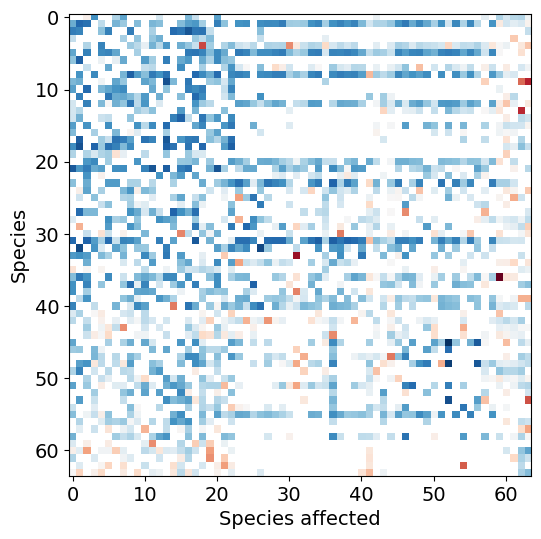

In [121]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(np.log10(shap_interactions[0]), cmap="RdBu",
            aspect='equal') 
ax.set_xlabel("Species affected")
ax.set_ylabel("Species")

### Integrated gradient

In [11]:
from captum.attr import IntegratedGradients

def calculate_global_ig_importance(p_model, p_data, samples_use = 1000):
    
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)

    class model_wrapper(nn.Module):
        def __init__(self, original_model):
            super().__init__()
            self.original_model = original_model

        def forward(self, x):
            b, nb, _, _ = self.original_model(x)
            return (b>0.5).float()*nb + (b<0.5).float()*(-1)

    model.eval()
    wrapped_model = model_wrapper(model).to(device)
    wrapped_model.eval()
    
    ig = IntegratedGradients(wrapped_model)
    all_attributions = []
    data_to_explain = X_train_scaled[:samples_use, :].to(device)
    background_data = 0*X_train_scaled.float().to(device)
    n_outputs = data_to_explain.shape[1]
    for i in tqdm(range(n_outputs)):
        attributions = ig.attribute(data_to_explain,
                                    target=i,
                                    baselines=background_data.mean(axis=0, keepdim=True))
        all_attributions.append(attributions.cpu().numpy())

    all_attributions_np = np.array(all_attributions) #(n_outputs, n_samples, n_features)
    
    return all_attributions_np


# load model and data
hub = 6
p_model = f"../models/synthetic_v4_trophic_{hub}_trained_AE.pt"
p_data = f"../data/synthetic_v4_trophic_{hub}_filtered.pt"
ig_scores = calculate_global_ig_importance(p_model, p_data, 500)

100%|██████████| 88/88 [00:47<00:00,  1.86it/s]


Text(0, 0.5, 'Species')

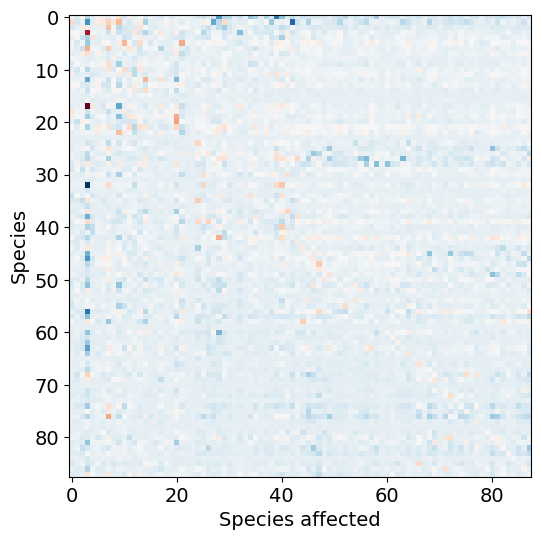

In [13]:
# calculate the keystone matrix
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
num_species = X_test_scaled.shape[1]
ig_interactions = np.zeros([num_species, num_species])
for i in range(num_species):
    for j in range(num_species):
        ig_interactions[i, j] = np.mean(ig_scores[j], axis=0)[i]
        
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(ig_interactions, cmap="RdBu",
            aspect='equal') 
ax.set_xlabel("Species affected")
ax.set_ylabel("Species")

### Invasiveness

In [164]:
from collections import defaultdict
from scipy.spatial.distance import braycurtis

def calculate_flip_invasiveness(p_model, p_data, batches_use=100):

    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
    class CustomDataset(Dataset):
        def __init__(self, features, labels, device=None):
            self.labels = labels
            self.features = features
        def __len__(self):
            return len(self.labels)
        def __getitem__(self, idx):
            label = self.labels[idx]
            data = self.features[idx]
            return {"Features": data, "Labels": label}
    Train = CustomDataset(X_train_scaled, y_train_scaled)
    Test = CustomDataset(X_test_scaled, y_test_scaled)
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
    test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)

    gmean, scaler = get_preprocess(p_data, p_model)
    zero_thr = 1e-8
    model.eval()

    num_species = X_test_scaled.shape[1]
    invader_distributions = defaultdict(list)
    inv_interactions = np.empty((num_species, num_species), dtype=object)
    for i in range(num_species):
        for j in range(num_species):
            inv_interactions[i, j] = []

    for bdx, batch in tqdm(enumerate(train_DS)):
        x = batch['Features'].to(device)
        with torch.no_grad():
            b, nb, *_ = model(x)
            recon_orig = (b>0.5).float()*nb + (b<0.5).float()*(-1)

        for i in range(x.shape[0]):
            x_i = x[i].clone()
            recon_i_scaled = recon_orig[i].cpu().numpy()
            if x_i.sum() == x_i.shape[0]:
                continue  # skip if all species are already present

            absent_indices = torch.nonzero(x_i == 0).flatten()

            # get the "unperturbed" abundances for all possible 0->1 flips of this sample
            recon_i_scaled_all = np.tile(recon_i_scaled, (len(absent_indices), 1))
            b_relab_all = np.tile(b[i].cpu().numpy(), (len(absent_indices), 1))
            orig_relab_all = preproc_inverse(recon_i_scaled_all, scaler)
            orig_relab_all = (b_relab_all>0.5)*orig_relab_all
            renorm_orig_relab_all = orig_relab_all.copy()
            # get the "perturbed" abundances for all possible 0->1 flips of this sample
            x_pert = torch.tile(x_i, (len(absent_indices), 1))
            for idx, j in enumerate(absent_indices):
                x_pert[idx, j.item()] = 1
            with torch.no_grad():
                b_pert, nb_pert, *_ = model(x_pert)
                recon_perturbed_scaled = (b_pert>0.5).float()*nb_pert + (b_pert<0.5).float()*(-1)
            perturbed_relab_all = preproc_inverse(recon_perturbed_scaled.cpu().numpy(), scaler)
            perturbed_relab_all = (b_pert.cpu().numpy()>0.5)*perturbed_relab_all
#             for idx, j in enumerate(absent_indices):
#                 perturbed_relab_all[idx, j.item()] = 0.0
#             perturbed_relab_all /= np.sum(perturbed_relab_all, axis=1, keepdims=True) 

            # get the bray-curtis distances
            for idx, j in enumerate(absent_indices):
                j = j.item()
                dist = braycurtis(orig_relab_all[idx], perturbed_relab_all[idx])
                invader_distributions[j].append(dist)

            # get the interactions
            difference = np.log10( (perturbed_relab_all+zero_thr)/(renorm_orig_relab_all+zero_thr) )
            for idx, j in enumerate(absent_indices):
                j = j.item()
                for jdx in range(num_species):
                    if(j!=jdx):
                        inv_interactions[j, jdx].append(difference[idx, jdx])

        bdx+=1
        if(bdx>=batches_use): break

    # Compute average invader score per species
    invader_scores = {
        i: np.mean(dists) for i, dists in invader_distributions.items()
    }
                
    return invader_scores, inv_interactions

In [165]:
# do this for all data
hubs_list = [1, 3, 6, 12, 24]
all_invader_scores = []
all_inv_interactions = []
all_annotations = []

for hub in hubs_list:
    p_model = f"../models/synthetic_v4_trophic_{hub}_trained_AE.pt"
    p_data = f"../data/synthetic_v4_trophic_{hub}_filtered.pt"
    
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]
    num_species = len(spc_names)
    
    invader_scores, inv_interactions = calculate_flip_invasiveness(p_model, p_data, 100)
    all_inv_interactions.append(inv_interactions)
    all_invader_scores.append(invader_scores)
    all_annotations.append(annotations)

80it [01:08,  1.17it/s]
80it [01:19,  1.01it/s]
80it [01:17,  1.04it/s]
80it [01:13,  1.09it/s]
80it [01:12,  1.10it/s]


In [166]:
def interaction_from_flip_invasiveness(inv_interactions, num_species):
    heatmap = np.zeros([num_species, num_species])
    xxs, xys = [], []
    for i in range(num_species):
        for j in range(num_species):
            if(len(inv_interactions[i, j])>0):
                heatmap[i, j] = np.mean(inv_interactions[i, j])
            else:
                xxs.append(i)
                xys.append(j)
    return heatmap, xxs, xys

pickle.dump({"all_inv_interactions": [interaction_from_flip_invasiveness(i, i.shape[0]) for i in all_inv_interactions], 
#              "all_key_interactions": all_key_interactions,
             "all_invader_scores": all_invader_scores, 
             "all_annotations": all_annotations}, 
            open("../synthetic_data/data_v4/invader_analysis.pkl", "wb"))

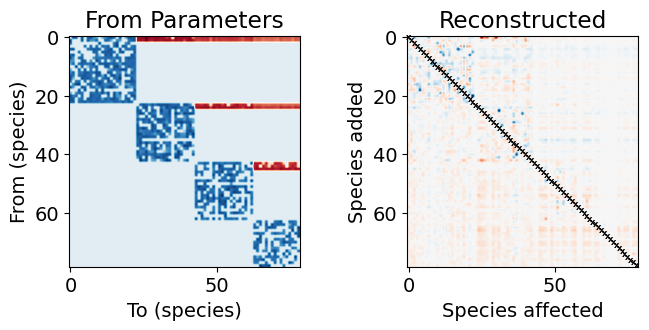

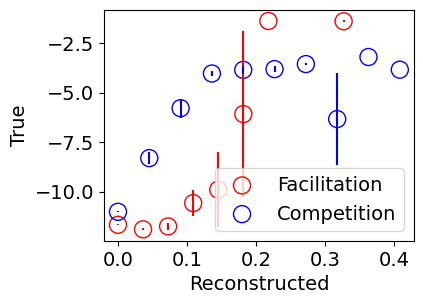

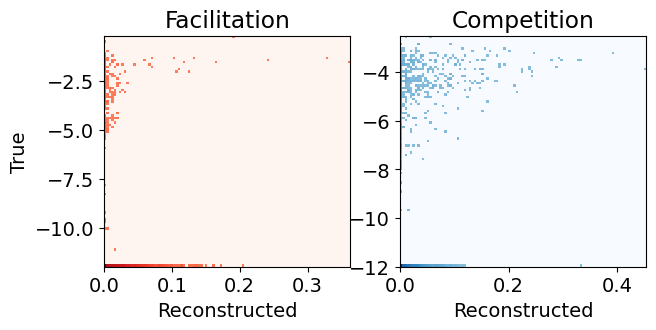

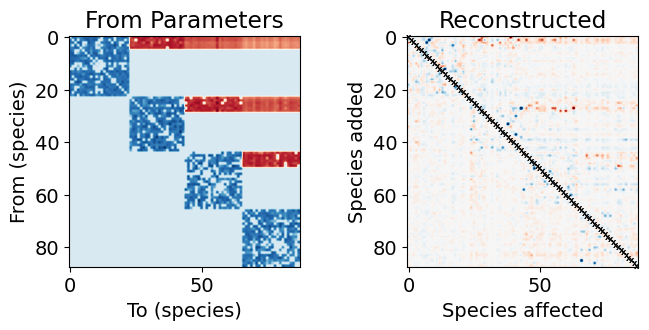

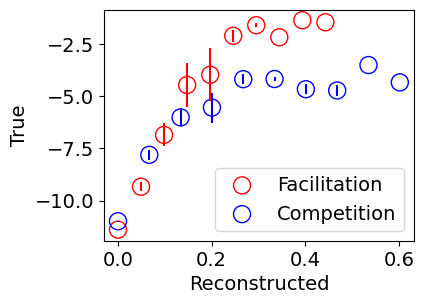

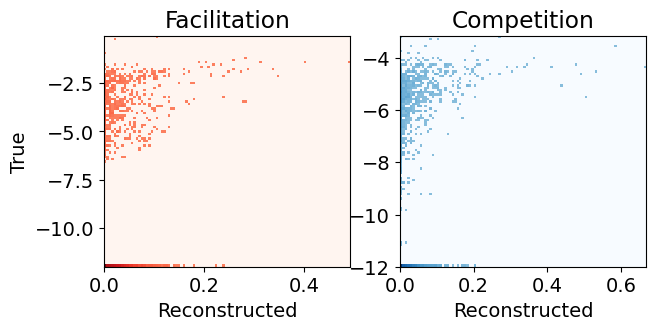

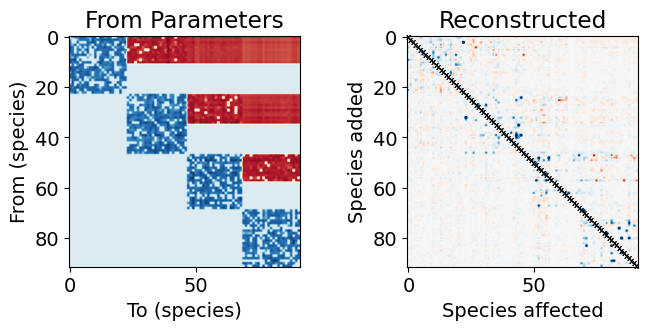

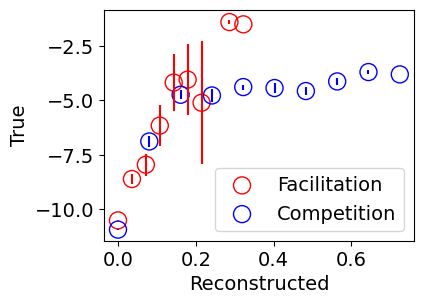

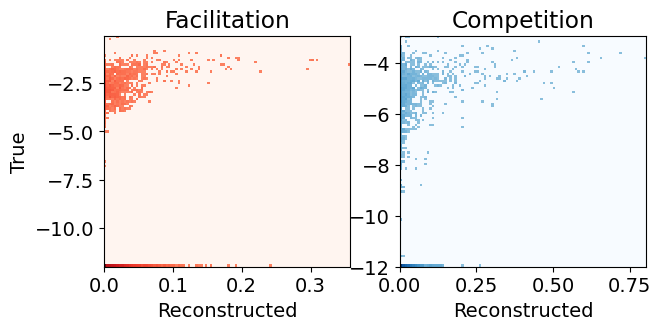

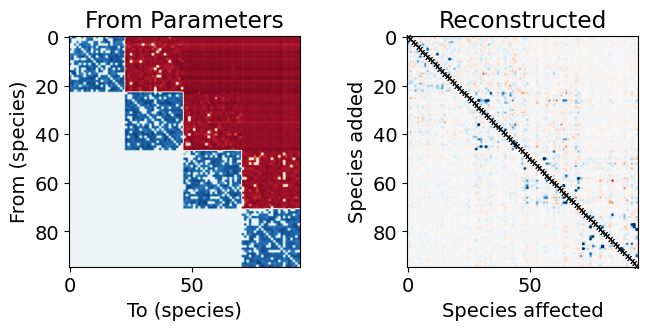

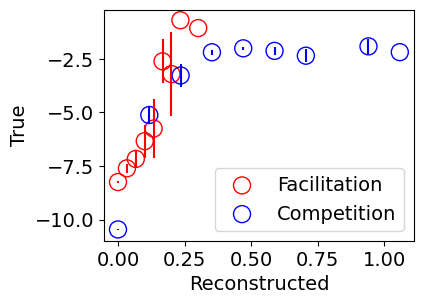

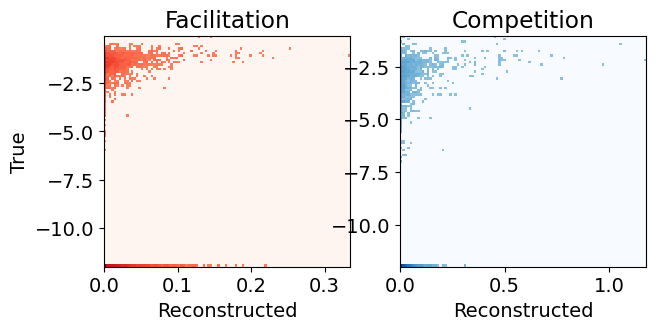

In [167]:
# make the interaction plots

# seems like this works less well than the keystoneness

data = pickle.load(open("../synthetic_data/data_v4/invader_analysis.pkl", "rb"))
all_inv_interactions = data["all_inv_interactions"]
all_invader_scores = data["all_invader_scores"]
all_annotations = data["all_annotations"]

for h_idx, hub in enumerate(hubs_list[1:]):
    
    heatmap, xxs, xys = all_inv_interactions[1:][h_idx]
    annotations = all_annotations[1:][h_idx]
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]
    
    p_params = f"../synthetic_data/data_v4/parameters_trophic_4_hubs_{hub}.pkl"
    p_Rs = f"../synthetic_data/data_v4/trophic_{hub}_all_diets_Rs.pkl"
    p_data = f"../synthetic_data/data_v4/trophic_{hub}_all_diets.pkl"
    params = pickle.load(open(p_params, "rb"))
    all_Rs = pickle.load(open(p_Rs, "rb"))
    all_Rs = all_Rs*(all_Rs>0)
    Rs = all_Rs.values[0, :]
    a_facil = mat_facil(params[0], 0.9, Rs) # f=0.9 used in simulations
    a_comp = mat_comp(params[0], 0.9, Rs)
    for i in range(a_comp.shape[0]):
        a_comp[i, i] = 0
    all_spcs = list(pickle.load(open(p_data, "rb")).columns)
    idxs = [i in spc_names for i in all_spcs]
    a_facil = a_facil[idxs, :][:, idxs]
    a_comp = a_comp[idxs, :][:, idxs]    
    
    handle = f"synthetic_v4_trophic_{hub}"
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].imshow(np.log10(1e-12-a_comp) - np.log10(1e-12+a_facil), cmap='RdBu')
    axs[0].set_ylabel("From (species)")
    axs[0].set_xlabel("To (species)")
    axs[0].set_title("From Parameters")
    axs[1].imshow(-heatmap, cmap="RdBu", vmin=-0.4, vmax=0.4) # most of values are within [-0.4, 0.4]
    for x, y in zip(xxs, xys):
        axs[1].text(x, y, 'x',
                color='black',
                ha='center',
                va='center',
                fontsize=6, 
                weight='bold')
    axs[1].set_xlabel("Species affected")
    axs[1].set_ylabel("Species added")
    axs[1].set_title("Reconstructed")
#     plt.savefig(f"../figures/keystoneness_i_to_j_{handle}.pdf", bbox_inches="tight")
    plt.show()
    
    
    x = (heatmap*(heatmap>0)).flatten()
    y = np.log10(1e-12+a_facil).flatten()
    x1, y1 = stratify_plot(x, y, 10) 
    plt.figure(figsize=(4, 3))
    plt.scatter(x1, [np.mean(i) for i in y1], s=150, facecolors="None", edgecolors="r", label="Facilitation")
    plt.errorbar(x1, [np.mean(i) for i in y1], yerr=[np.std(i)/np.sqrt(len(i)) for i in y1], linestyle="None", color="r")
    plt.xlabel("Reconstructed")
    plt.ylabel("True")

    x = (-heatmap*(heatmap<0)).flatten()
    y = np.log10(1e-12-a_comp).flatten()
    x1, y1 = stratify_plot(x, y, 10) 
    # plt.figure(figsize=(4, 3))
    plt.scatter(x1, [np.mean(i) for i in y1], s=150, facecolors="None", edgecolors="b", label="Competition")
    plt.errorbar(x1, [np.mean(i) for i in y1], yerr=[np.std(i)/np.sqrt(len(i)) for i in y1], linestyle="None", color="b")
    plt.xlabel("Reconstructed")
    plt.ylabel("True")
    plt.legend()
#     plt.savefig(f"../figures/keystoneness_i_to_j_compare1{handle}.pdf", bbox_inches="tight")
    plt.show()
    
    
    # actual correlation...
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    axs[0].hist2d(x = (heatmap*(heatmap>0)).flatten(), y = np.log10(1e-12+a_facil).flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='Reds', bins=100)
    axs[1].hist2d(x = (-heatmap*(heatmap<0)).flatten(), y = np.log10(1e-12-a_comp).flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='Blues', bins=100)

    axs[0].set_xlabel("Reconstructed")
    axs[0].set_ylabel("True")
    axs[0].set_title("Facilitation")
    axs[1].set_xlabel("Reconstructed")
    axs[1].set_title("Competition")
#     plt.savefig(f"../figures/keystoneness_i_to_j_compare2{handle}.pdf", bbox_inches="tight")
    plt.show()

#### Correlating invasiveness with keystoneness

Text(0.02, 0.98, 'Pearson r=0.857')

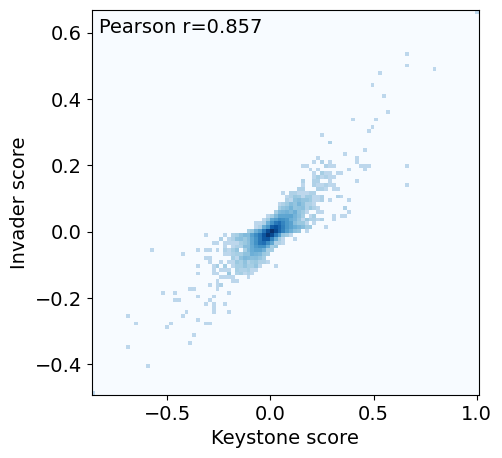

In [10]:
data = pickle.load(open("../synthetic_data/data_v4/invader_analysis.pkl", "rb"))
all_inv_interactions = data["all_inv_interactions"]
all_invader_scores = data["all_invader_scores"]
all_annotations = data["all_annotations"]

data = pickle.load(open("../synthetic_data/data_v4/keystone_analysis.pkl", "rb"))
all_key_interactions = data["all_key_interactions"]
all_keystone_scores = data["all_keystone_scores"]
all_annotations = data["all_annotations"]

h_idx = 2
heatmap1, xxs1, xys1 = all_key_interactions[h_idx]
heatmap2, xxs2, xys2 = all_inv_interactions[h_idx]
annotations = all_annotations[h_idx]
spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]

keys = []
invs = []
for i in range(heatmap1.shape[0]):
    for j in range(heatmap1.shape[1]):
        if((i, j) not in zip(xxs1, xys1) and (i, j) not in zip(xxs2, xys2)):
            keys.append(heatmap1[i, j])
            invs.append(-heatmap2[i, j])

r, p = stats.pearsonr(keys, invs)
plt.figure(figsize=(5, 5))
plt.hist2d(x=keys, y=invs, cmap='Blues', norm=matplotlib.colors.PowerNorm(1/5), bins=100)
plt.xlabel("Keystone score")
plt.ylabel("Invader score")
plt.text(0.02, 0.98, f'Pearson r={r:.3f}', transform=plt.gca().transAxes, va='top')